## Imports

In [136]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re 
import seaborn as sns
import seaborn.objects as so
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from typing import NewType 

## import data and cleaning

In [137]:
df = pd.read_csv(r'/Users/michaelschaid/Desktop/Guided Project Predicting House Sale Prices/AmesHousing.tsv', delimiter='\t')
df.head()


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [138]:

def tweak_homes(df):
    
    def null_counts(df: pd.DataFrame, upper_lim: float, lower_lim = 0) -> tuple:
        """Calculate the percentage of missing values in each column and return:
                a list of column names that should be imputed. 
                a list of column names that should be dropped.
        """
    #calculate missing values percentage and return 
        null_counts = pd.DataFrame(df.isnull().sum()/df.shape[0], columns=['null_counts'])
        cols_impute = null_counts.query("null_counts > @lower_lim & null_counts < @upper_lim").index.to_list()
        cols_drop = null_counts.query("null_counts >= @upper_lim").index.to_list()
        return cols_impute, cols_drop
    # null_cols = null_counts(df, 0.05)
    
    def to_category(df_)-> list:
        return df_.astype({c: 'category' for c in df_.select_dtypes('object').columns})
    
    def group_col_names(df,term):
        return [col for col in df.columns if re.search(term, col)]
    
    
    return (df
            .drop(columns = null_counts(df, 0.05)[1]) #  drop columns with more than 5% missing values
            .drop(columns = ['PID', 'Order']) #  drop identifier columns that are not useful for modeling
            .fillna(value = {c: df[c].mean() for c in df.select_dtypes('number').columns}) #  impute numerical columns and fill with mean value
            .rename(lambda col: col.replace(' ', '_').lower(), axis=1) #  rename columns to lowercase and replace spaces with underscores
            .pipe(lambda df_: to_category(df_)) #  convert object columns to category
            .assign(year_until_remod = lambda df_: df_['year_remod/add'] - df_['year_built'],  # years between remod and built
                    total_sf = lambda df_: df_[group_col_names(df_, 'sf')].sum(axis=1), # total square footage
                    total_area = lambda df_: df_[group_col_names(df_, 'area')].sum(axis=1), # total area
                    # 
                    
                    
                    
                    )
            
            
            )
homes = tweak_homes(df)


### Basic EDA of numerical features

#### year remodeled, year built, and  $\Delta$year_remod - year_built are correlated to sales price

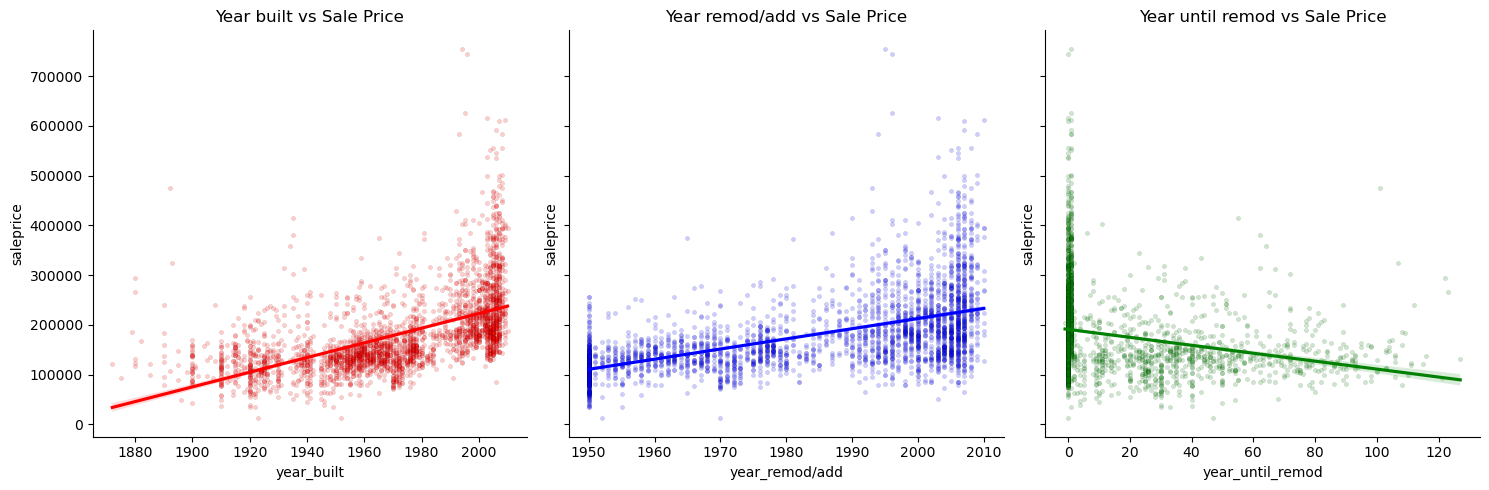

In [282]:
def year_plot(col, ax, color):
    #  function to make plots for year columns
    kws_={"s": 10,
          'alpha': 0.2,
          'edgecolor': 'black',
          'linewidth': 0.2
          }
    sns.regplot(x=col, y='saleprice', data=homes, ax=ax, color=color, scatter_kws=kws_)
    sns.despine()
    ax.set_title(f'{col.replace("_", " ").capitalize()} vs Sale Price')

#  figure generation
fig, ax = plt.subplots(figsize=(15,5), ncols=3, sharey=True)
year_plot('year_built', ax[0], color='red')
year_plot('year_remod/add', ax[1], color='blue')
year_plot('year_until_remod', ax[2], color='green')
plt.tight_layout()
plt.show()



## Total area and total sf are superior predictors for saleprice. 

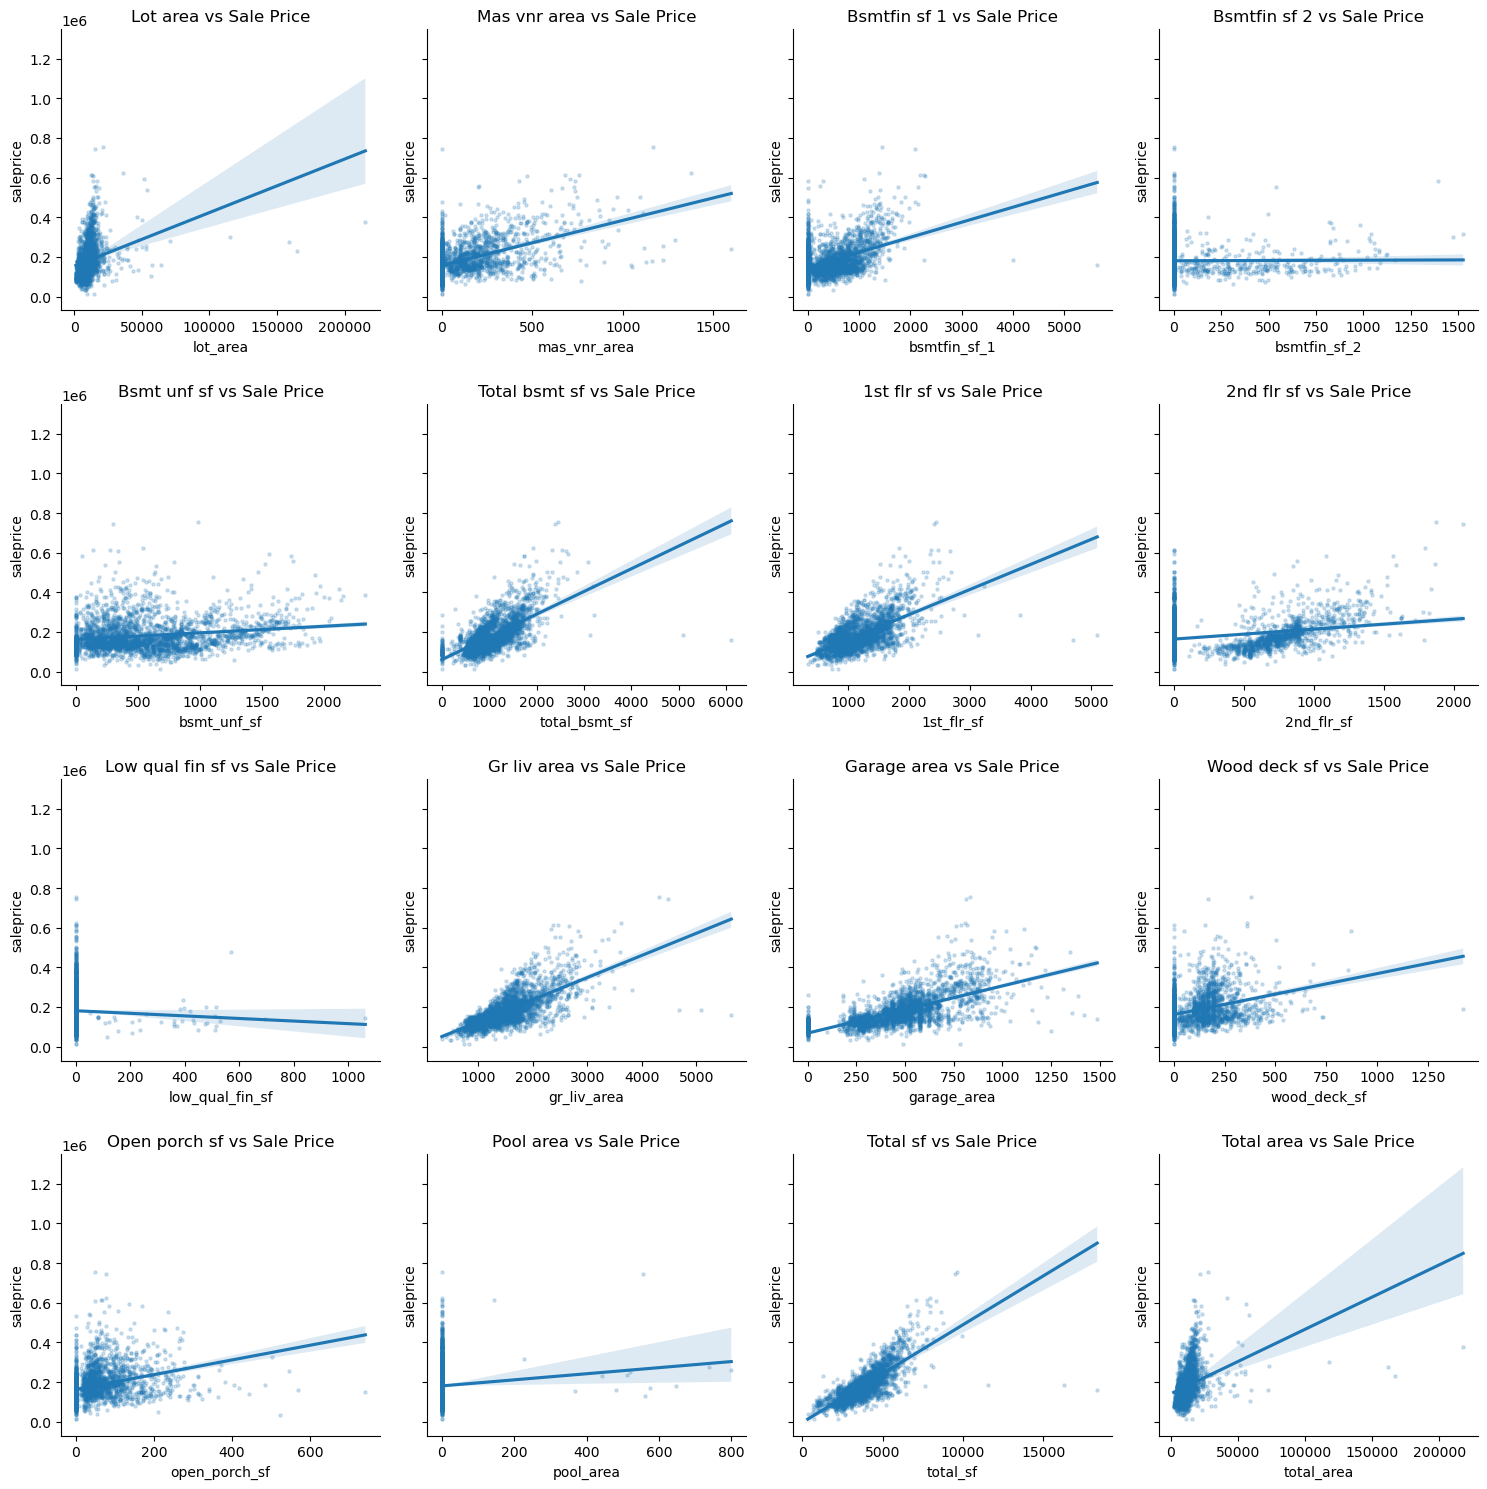

In [140]:
sqr_footage = [col for col in homes.columns if re.search(r'sf|area', col)] +['saleprice']

def make_reg_panel(cols):
    number_subplots = len(cols)-1
    grid_sqr= int(np.ceil(np.sqrt(number_subplots)))
    fig, ax = plt.subplots(figsize=(15,15), ncols=grid_sqr, nrows=grid_sqr, sharey=True)
    
    for col, ax in zip(cols, ax.flatten()):
        if col !='saleprice':
            kws_={"s": 5,'alpha': 0.2}
            sns.regplot(x=col, y='saleprice', data=homes, ax=ax, scatter_kws=kws_)
            ax.set_title(f'{col.replace("_", " ").capitalize()} vs Sale Price')
            sns.despine(ax=ax)
    
    plt.tight_layout()
    plt.show()

make_reg_panel(sqr_footage)

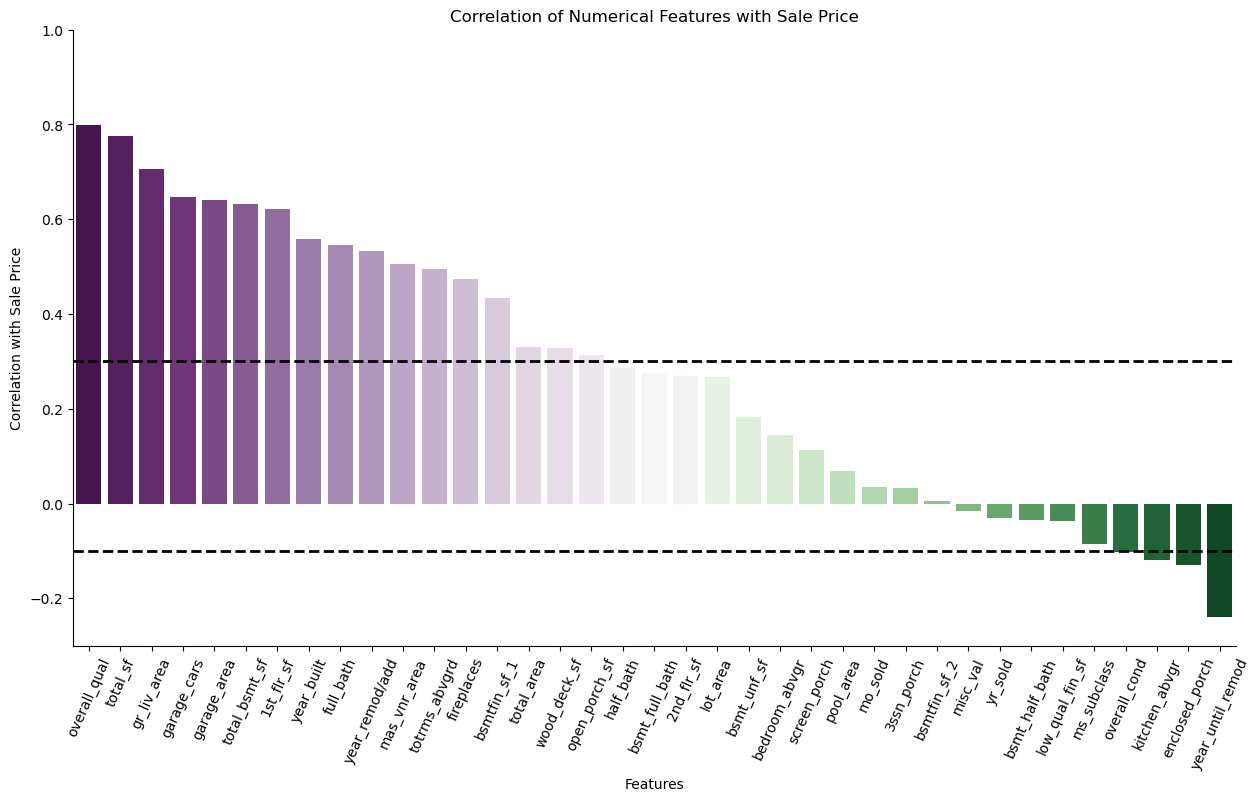

In [141]:

format = {
       'xlabel':'Features', 
       'ylabel':'Correlation with Sale Price',
       'title':'Correlation of Numerical Features with Sale Price',
       "ylim": (-0.3, 1)         
}
corr = pd.DataFrame(homes.corr()['saleprice'].sort_values(ascending=False))

def drawlines(*args):
       for arg in args:
              ax.axhline(arg, color='black', linestyle='--', linewidth=2)
              
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=corr.iloc[1:], x=list(corr.iloc[1:].index), y='saleprice', palette='PRGn', ax=ax)

ax.set(**format)

plt.xticks(rotation=66)
drawlines(*(0.3, -0.1))
sns.despine()
plt.show()


#### numerical summary:  Selecting columns of a correlation over |0.2|. However, PID and order are identifiers, which dont provide any actual data for correlation analysis. Drop

### EDA of categorigcal features

### neighborhood correlates mildly with overall_qual and saleprice, house_style not so mnuch 

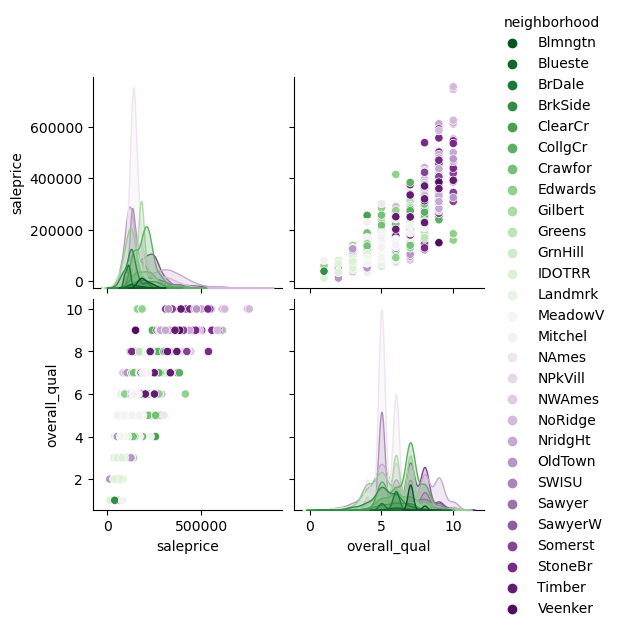

In [145]:
sns.pairplot(data=homes[['saleprice', 'overall_qual', 'neighborhood']], hue='neighborhood', palette='PRGn_r')

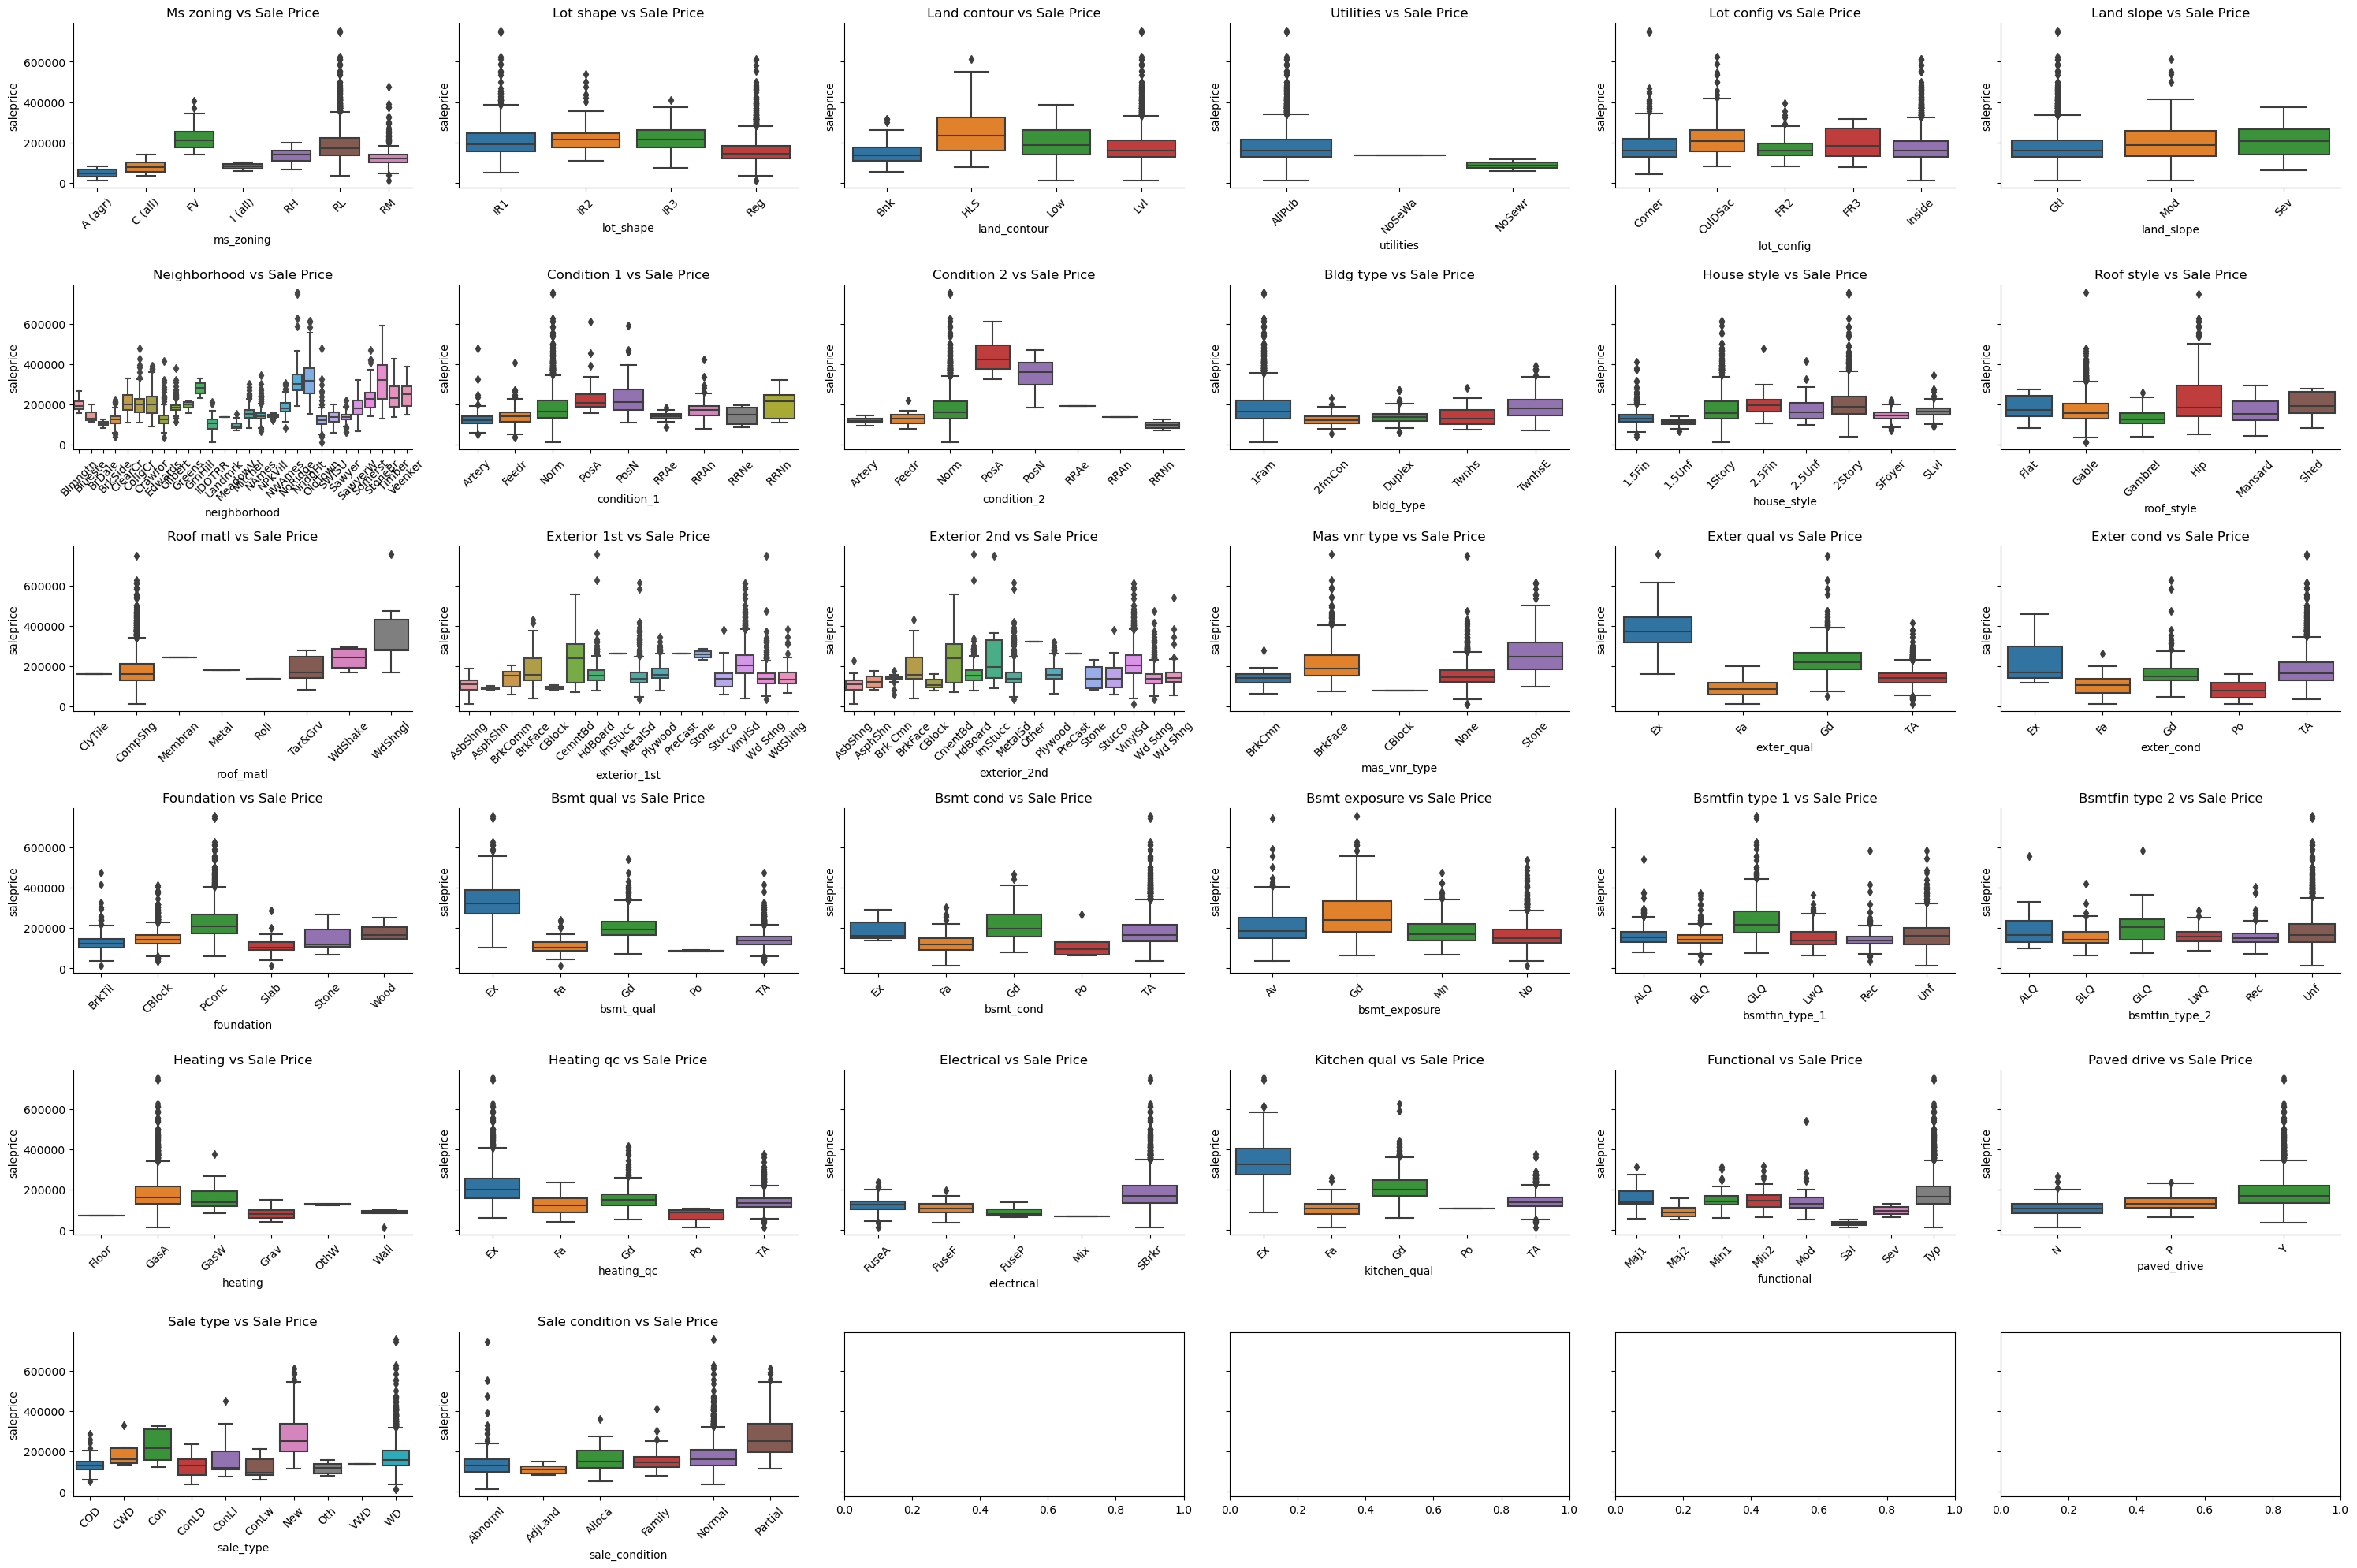

In [185]:
def plot_categorical(cat_threshold = 2):
    homes_cat = homes[homes.select_dtypes('category').columns.tolist() + ['saleprice']]
    homes_cat_gt5 = homes_cat[homes_cat.nunique()[homes_cat.nunique() > cat_threshold].index.to_list()].columns.to_list()
    panel_numb = len(homes_cat_gt5)-1
    grid_numb = int(np.ceil(np.sqrt(panel_numb)))
    
    fig, ax = plt.subplots(ncols=grid_numb, nrows=grid_numb, figsize=(30,20), sharey=True)
    for col, ax in zip(homes_cat_gt5, ax.flatten()):
        if col !='saleprice':
            sns.boxplot(x=col, y='saleprice', data=homes_cat, ax=ax)
            ax.set_title(f'{col.replace("_", " ").capitalize()} vs Sale Price')
            sns.despine(ax=ax)
            ax.tick_params(axis='x', rotation=45)
            
    plt.tight_layout()
    plt.show()
    
   
   
   
plot_categorical()


## Summary of Catetogical Features

> Exterior 1 and 2 seem to have low correlation to sale price - drop in feature extraction

> neighborhood is mildly correlated with sale price, however, its not the strogest, and there is a high degree of variance. It is likely that this is not a strong predictor of sale price so we will drop this column in our model building, but keep it in our dataprocessing pipeline incase needed in the futre. 

> house style also seems to have no correlation to sale price -drop




In [273]:


        

cat_to_drop = ['land_slope', 'lot_config'] + drop_area_cols
all_cat = [ c for c in homes.select_dtypes('category').columns.tolist() if c not in cat_to_drop]

cat_dum = pd.get_dummies(homes[all_cat])


feature_dummies = pd.concat([homes, cat_dum], axis=1).drop(columns=all_cat)
feature_dummies

processed_homes =pd.concat([homes.select_dtypes('number'), feature_dummies])

format = {
       'xlabel':'Features', 
       'ylabel':'Correlation with Sale Price',
       'title':'Correlation of All Numerical Features with Sale Price',
       "ylim": (-0.3, 1)         
}
processed_corr = pd.DataFrame(processed_homes.corr()['saleprice'].sort_values(ascending=False))

       

fig, ax = plt.subplots(figsize=(30, 5))
sns.barplot(data=processed_corr.iloc[1:], x=list(processed_corr.iloc[1:].index), y='saleprice', palette='PRGn', ax=ax)

ax.set(**format)

plt.xticks(rotation=90)
drawlines(*(0.3, -0.1))
sns.despine()
ax.annotate('lines indicate threshold criteria for feature selection', xy=(150, 1), xytext=(70, 0.5))


,ms_subclass,lot_area,lot_config,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,...,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD,sale_condition_Abnorml,sale_condition_AdjLand,sale_condition_Alloca,sale_condition_Family,sale_condition_Normal,sale_condition_Partial
0,20,31770,Corner,Gtl,6,5,1960,1960,112.0,639.0,...,0,0,0,1,0,0,0,0,1,0
1,20,11622,Inside,Gtl,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
2,20,14267,Corner,Gtl,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
3,20,11160,Corner,Gtl,7,5,1968,1968,0.0,1065.0,...,0,0,0,1,0,0,0,0,1,0
4,60,13830,Inside,Gtl,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,7937,CulDSac,Gtl,6,6,1984,1984,0.0,819.0,...,0,0,0,1,0,0,0,0,1,0
2926,20,8885,Inside,Mod,5,5,1983,1983,0.0,301.0,...,0,0,0,1,0,0,0,0,1,0
2927,85,10441,Inside,Gtl,5,5,1992,1992,0.0,337.0,...,0,0,0,1,0,0,0,0,1,0
2928,20,10010,Inside,Mod,5,5,1974,1975,0.0,1071.0,...,0,0,0,1,0,0,0,0,1,0


In [271]:
def filter_correlated_features(lower_threshold, upper_threshold):
    corr = pd.DataFrame(processed_homes
                        .corr()['saleprice']
                        .sort_values(ascending=False)
                        )
    return (corr
            .query("saleprice < @lower_threshold or saleprice > @upper_threshold")
            .drop('saleprice', axis=0)
            .index
            .to_list())

filter_correlated_features(-0.1, 0.3)

['overall_qual',
 'total_sf',
 'gr_liv_area',
 'garage_cars',
 'garage_area',
 'total_bsmt_sf',
 '1st_flr_sf',
 'bsmt_qual_Ex',
 'year_built',
 'full_bath',
 'kitchen_qual_Ex',
 'year_remod/add',
 'foundation_PConc',
 'mas_vnr_area',
 'totrms_abvgrd',
 'exter_qual_Ex',
 'fireplaces',
 'bsmtfin_type_1_GLQ',
 'heating_qc_Ex',
 'exter_qual_Gd',
 'bsmtfin_sf_1',
 'bsmt_exposure_Gd',
 'sale_type_New',
 'sale_condition_Partial',
 'total_area',
 'wood_deck_sf',
 'open_porch_sf',
 'kitchen_qual_Gd',
 'mas_vnr_type_Stone',
 'bldg_type_Duplex',
 'bldg_type_2fmCon',
 'overall_cond',
 'bldg_type_Twnhs',
 'sale_type_COD',
 'bsmtfin_type_1_Unf',
 'foundation_Slab',
 'condition_1_Artery',
 'condition_1_Feedr',
 'ms_zoning_C (all)',
 'kitchen_abvgr',
 'bsmtfin_type_1_BLQ',
 'electrical_FuseF',
 'exter_qual_Fa',
 'enclosed_porch',
 'heating_qc_Fa',
 'heating_qc_Gd',
 'sale_condition_Abnorml',
 'bsmt_cond_Fa',
 'exter_cond_Fa',
 'sale_condition_Normal',
 'kitchen_qual_Fa',
 'bsmt_qual_Fa',
 'bsmtfin_typ

### data preprocessing

In [ ]:
RMSE = NewType('RMSE', float)

def train_and_test(df:pd.DataFrame)->RMSE:
    """## Summary
    funtion takes in dataframe specific to homes data, trains linear regression model, and returns RMSE
    

    ### Args:
        df (pd.DataFrame): pd.DataFrame

    ### Returns:
        RMSE:float -  root mean squared error of the model 
    """
    #split data into train and test sets

    
    homes_train, homes_test = train_test_split(df.dropna(), test_size=0.3, random_state=0)
    
    #select numberical columns
    features = df.select_dtypes(['float', 'int']).drop('saleprice', axis=1).columns
    target = 'saleprice'
    
    
    #  instantiate linear regression model and train
    regr = LinearRegression().fit(homes_train[features], homes_train[target])
    sales_predictions = regr.predict(homes_test[features])
    rmse = np.sqrt(mean_squared_error(homes_test[target], sales_predictions))
    return rmse
    
    
def transform_features():
    return homes_train

def select_features():
    return homes_train[['gr_liv_area', 'saleprice']]



In [ ]:
train_and_test(homes)